<a href="https://colab.research.google.com/github/Pauline0115/Pauline0115.github.io/blob/main/Experiment_2(weight_initializer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initialization

## Environment Setup

In [1292]:
import numpy as np #提供數據庫&處理函數
import pandas as pd #提供数据分析和数据操作
import matplotlib.pyplot as plt #繪圖
import math

In [1293]:
from sklearn.model_selection import train_test_split #提供模型選擇、交叉驗證、數據集拆分、评估模型性能的工具
from sklearn.preprocessing import StandardScaler #數據預處理标准化、缩放、编码、填充缺失值

In [1294]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split #random_split隨機地將數據分成多個子集

## Data

In [1295]:
from sklearn.datasets import load_iris #函數load_iris加載鳶尾花數據集
from sklearn.preprocessing import OneHotEncoder

iris = load_iris() #函数加載鳶尾花數據集，并返回一個包含數據和標籤的對象
X = iris.data #特徵
y = iris.target #標籤

In [1296]:
# y to one-hot encoding
y = y.reshape(-1, 1) # parse to 2D to encoder
encoder = OneHotEncoder(sparse_output=False) # False return a numpy 稀疏矩陣sparse在儲存非0元素位置&值
y = encoder.fit_transform(y) #OneHotEncoder 需要接收的目标变量 y 必须是一个二维数组(有標籤及樣本)或者矩阵，因為实际应用中，通常有多個样本，每個样本有一個类别

In [1297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1298]:
len(y[0])

3

#Build NN
<img width="400" src="https://lh3.google.com/u/0/d/1LQm-3bMxBxhq0jSNEWyXgijbbSfLLbVr=w2992-h1654-iv2"></img>

In [1299]:
import torch.nn.init as init
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1,  hidden_size2, output_size, weight_initializer):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1)  # First hidden layer
    self.relu = nn.ReLU()  # ReLU activation function
    self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Output layer
    self.fc3 = nn.Linear(hidden_size2, output_size)  # Output layer

    self._initialize_weight(weight_initializer)

  @staticmethod
  def he_normal_init_weight(m): #參數m表示神经網路的某一層
      if isinstance(m, nn.Linear): #檢查输入的 m 是否是 PyTorch 中的線性層 (nn.Linear)
          fan_in = m.weight.size(1) #輸入特徵的數量
          std = math.sqrt(2.0 / fan_in)
          m.weight.data.normal_(0, std) #對權重進行正態分佈初始化，均值為 0-->初始值是從均值為0的正態分佈中取得的
          if m.bias is not None:
              m.bias.data.zero_() #檢查是否存在偏置項，如果存在偏置項，將其初始化為零。

  @staticmethod
  def self_defined_init_weight(m):
      if isinstance(m, nn.Linear):
          fan_in = m.weight.size(1) #表示權重張量的第二個維度的大小，即輸入特徵數。
          fan_out = m.weight.size(0) #表示權重張量的第一個維度的大小，即輸出特徵數。
          std_dev = (math.sqrt(2.0 / fan_in)) + (math.sqrt(1.0 / fan_out))
          m.weight.data.normal_(0, std_dev)
          if m.bias is not None:
              m.bias.data.zero_()

  @staticmethod
  def self2_defined_init_weight(m):
      if isinstance(m, nn.Linear):
          fan_in = m.weight.size(1) #表示權重張量的第二個維度的大小，即輸入特徵數。
          fan_out = m.weight.size(0) #表示權重張量的第一個維度的大小，即輸出特徵數。
          #std_dev = math.sqrt(2.0 / (fan_in * fan_out))
          #m.weight.data.normal_(0, std_dev)
          if m.bias is not None:
              m.bias.data.zero_()



  def _initialize_weight(self, weight_initializer):
    if weight_initializer == "he":
        self.apply(NeuralNetwork.he_normal_init_weight)
    elif weight_initializer == "self":
        self.apply(NeuralNetwork.self_defined_init_weight)


  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)

    return F.softmax(out, dim=1) #Softmax 函數用於多類別分類問題，將模型的原始輸出轉換為類別概率分佈。對模型的輸出 out 進行 softmax 操作，
                    #dim=1 表示在第一個維度上進行 softmax，通常這個維度對應於類別。結果是一個包含每個類別概率的張量

In [1300]:
he_model = NeuralNetwork(X_train.shape[1], 128, 64, 3, "he")
self_model = NeuralNetwork(X_train.shape[1], 128, 64, 3, "self1")

In [1301]:
he_optimizer = optim.Adam(he_model.parameters(), lr=0.001)
self_optimizer = optim.Adam(self_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training
* metrics: convergence time

In [1302]:
def calculate_accuracy(y_true, y_pred):
    # print(y_true, y_pred)
    predicted = torch.argmax(y_pred, dim=1) # get the most like class
    gt = torch.argmax(y_true, dim=1) #torch.argmax 函數返回最大值的索引，dim=1 表示在第一個維度（通常是類別的維度）上進行操作

    correct = (predicted == gt).float().sum()

    return correct.item() / float(len(gt)) #準確率

In [1303]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [1304]:
train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size

In [1305]:
# Create a DataLoader for your training data
train_dataset = TensorDataset(X_train, y_train)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [1306]:
# Define epoch
num_epochs = 100

# He Normal

In [1269]:
train_losses = []  # list to store loss values
val_losses = []
train_accs = []

train_preds = []
val_preds = []
val_accs = []

for epoch in range(num_epochs):

    # training phase
    he_model.train()
    train_loss = 0
    train_acc = 0.0

    for data in train_loader: # a batch
        inputs, labels = data
        he_optimizer.zero_grad()  # Zero the gradient buffers
        outputs = he_model(inputs)  # Get network outputs (forward propagation)
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss (backward propagation)
        he_optimizer.step()  # Update the weights

        train_loss += loss.item()  # accumulate loss per batch
        train_preds += outputs

        train_acc += calculate_accuracy(labels, outputs)

    train_loss /= len(train_loader)  # average loss for the epoch
    train_losses.append(train_loss)  # store average loss for the epoch

    train_acc = train_acc / len(train_loader)
    train_accs.append(train_acc)

    # validation phase
    he_model.eval()
    val_loss = 0
    val_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            outputs = he_model(data) # forward propagation
            loss = loss_fn(outputs, target)

            val_loss += loss.item()
            val_preds += outputs
            val_acc += calculate_accuracy(target, outputs)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valiation Loss: {val_loss}, Training Acc: {train_acc}, Validation Acc: {val_acc}')

Epoch 1/100, Train Loss: 1.080669641494751, Valiation Loss: 1.0119456052780151, Training Acc: 0.4479166666666667, Validation Acc: 0.5833333333333334
Epoch 2/100, Train Loss: 0.9542955160140991, Valiation Loss: 1.0253039598464966, Training Acc: 0.6666666666666666, Validation Acc: 0.5833333333333334
Epoch 3/100, Train Loss: 0.913584291934967, Valiation Loss: 0.9742433428764343, Training Acc: 0.6770833333333334, Validation Acc: 0.5833333333333334
Epoch 4/100, Train Loss: 0.8853321472803751, Valiation Loss: 0.9420018792152405, Training Acc: 0.6770833333333334, Validation Acc: 0.5833333333333334
Epoch 5/100, Train Loss: 0.8810034195582072, Valiation Loss: 0.9409257769584656, Training Acc: 0.6770833333333334, Validation Acc: 0.5833333333333334
Epoch 6/100, Train Loss: 0.8698584040006002, Valiation Loss: 0.9516056180000305, Training Acc: 0.6770833333333334, Validation Acc: 0.5833333333333334
Epoch 7/100, Train Loss: 0.8695005973180135, Valiation Loss: 0.9541962146759033, Training Acc: 0.67708

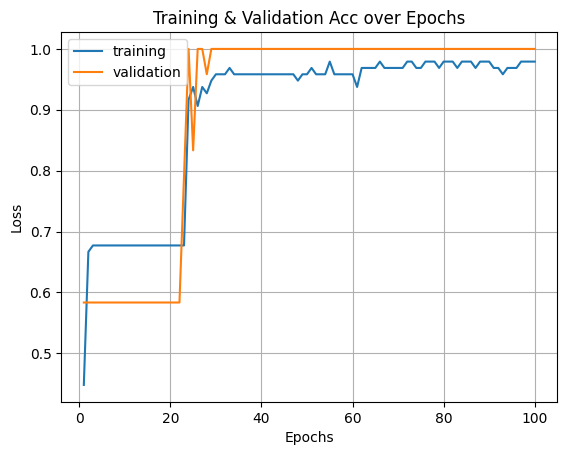

In [1270]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label="training")
plt.plot(range(1, num_epochs+1), val_accs, label="validation")

plt.title('Training & Validation Acc over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# Self Normal

### Self_1 Normal


In [1286]:
train_losses = []  # list to store loss values
val_losses = []
train_accs = []

train_preds = []
val_preds = []
val_accs = []

for epoch in range(num_epochs):

    # training phase
    self_model.train()
    train_loss = 0
    train_acc = 0.0

    for data in train_loader: # a batch
        inputs, labels = data
        self_optimizer.zero_grad()  # Zero the gradient buffers
        outputs = self_model(inputs)  # Get network outputs (forward propagation)
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss (backward propagation)
        self_optimizer.step()  # Update the weights

        train_loss += loss.item()  # accumulate loss per batch
        train_preds += outputs

        train_acc += calculate_accuracy(labels, outputs)

    train_loss /= len(train_loader)  # average loss for the epoch
    train_losses.append(train_loss)  # store average loss for the epoch

    train_acc = train_acc / len(train_loader)
    train_accs.append(train_acc)

    # validation phase
    self_model.eval()
    val_loss = 0
    val_acc = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            outputs = self_model(data) # forward propagation
            loss = loss_fn(outputs, target)

            val_loss += loss.item()
            val_preds += outputs
            val_acc += calculate_accuracy(target, outputs)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valiation Loss: {val_loss}, Training Acc: {train_acc}, Validation Acc: {val_acc}')

Epoch 1/100, Train Loss: 1.0987650950749714, Valiation Loss: 1.1043896675109863, Training Acc: 0.3645833333333333, Validation Acc: 0.25
Epoch 2/100, Train Loss: 1.0806134939193726, Valiation Loss: 1.0835009813308716, Training Acc: 0.3645833333333333, Validation Acc: 0.25
Epoch 3/100, Train Loss: 1.0655018488566081, Valiation Loss: 1.0644581317901611, Training Acc: 0.3645833333333333, Validation Acc: 0.5416666666666666
Epoch 4/100, Train Loss: 1.0541845162709553, Valiation Loss: 1.0484529733657837, Training Acc: 0.4895833333333333, Validation Acc: 0.375
Epoch 5/100, Train Loss: 1.0413065751393635, Valiation Loss: 1.0279196500778198, Training Acc: 0.375, Validation Acc: 0.7083333333333334
Epoch 6/100, Train Loss: 1.0280130704243977, Valiation Loss: 1.0054004192352295, Training Acc: 0.59375, Validation Acc: 0.75
Epoch 7/100, Train Loss: 1.01059095064799, Valiation Loss: 0.9821653962135315, Training Acc: 0.6354166666666666, Validation Acc: 0.75
Epoch 8/100, Train Loss: 0.9943520029385885, 

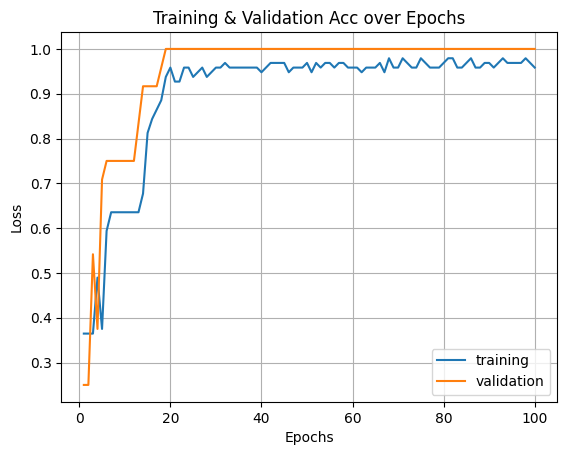

In [1287]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label="training")
plt.plot(range(1, num_epochs+1), val_accs, label="validation")

plt.title('Training & Validation Acc over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='best')
plt.show()